In [1]:
import os

os.chdir('../Few_Shot_Seg_CWT')
os.getcwd()

'/Users/nigel/Documents/Research-Git/Few_Shot_Seg_CWT'

# Dataset.py

*Import Packages*

In [2]:
import cv2
import torch
import random
import argparse
import numpy as np
from typing import List
from torch.utils.data import Dataset
from torchvision import transforms as T
from torch.utils.data.distributed import DistributedSampler

import src.dataset.transform as transform
from src.dataset.utils import make_dataset
from src.dataset.classes import get_split_classes, filter_classes

### StandardData

In [3]:
class StandardData(Dataset):
  def __init__(self, args: argparse.Namespace,
               transform: transform.Compose,
               data_list_path: str,
               class_list: List[int],
               return_paths: bool):
    self.data_root = args.data_root                                              # path to dataset directory
    self.class_list = class_list                                                 # dict of containing two dicts (pascal & coco), mapping the classes that corresponds to different dataset splits
    self.data_list, _ = make_dataset(args.data_root, data_list_path, class_list) # return a tuple with: 1, a List of all (image_path, label_path) Tuples; 2, a Dict mapping (image_path, label_path) Tuples for different classes
    self.transform = transform                                                   # Composed transformation for dataset
    self.return_paths = return_paths                                             # whether to return image&label path in __getitem__

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, index):

      # read image and labels
      image_path, label_path = self.data_list[index]
      image = cv2.imread(image_path, cv2.IMREAD_COLOR)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = np.float32(image)
      label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

      # double check to make sure the shape matches
      if image.shape[0] != label.shape[0] or image.shape[1] != label.shape[1]:
        raise (RuntimeError("Query Image & label shape mismatch: " + image_path + " " + label_path + "\n"))

      # remove unwanted label classes
      label_class = np.unique(label).tolist()
      if 0 in label_class:
        label_class.remove(0)
      if 255 in label_class:
        label_class.remove(255)

      new_label_class = []
      undesired_class = []
      for c in label_class:
        if c in self.class_list:
          new_label_class.append(c)
        else:
          undesired_class.append(c)
      label_class = new_label_class
      assert len(label_class) > 0

      new_label = np.zeros_like(label)                                           # background
      for lab in label_class:
        indexes = np.where(label == lab)
        new_label[indexes[0], indexes[1]] = self.class_list.index(lab) + 1       # Add 1 because class 0 is for bg
      for lab in undesired_class:
        indexes = np.where(label == lab)
        new_label[indexes[0], indexes[1]] = 255

      if self.transform is not None:
        image, new_label = self.transform(image, new_label)
      if self.return_paths:
        return image, new_label, image_path, label_path
      else:
        return image, new_label

### EpisodicData

In [4]:
class EpisodicData(Dataset):
  def __init__(self,
                mode_train: bool,
                dt_transform: transform.Compose,
                class_list: List[int],
                args: argparse.Namespace):

    self.shot = args.shot
    self.padding = [v*255 for v in args.mean] if args.get('padding')=='avg' else None
    self.meta_aug = args.get('meta_aug', 0)
    self.aug_th = args.get('aug_th', [0.15, 0.30])
    self.aug_type = args.get('aug_type', 0)
    self.args = args

    self.random_shot = args.random_shot
    self.data_root = args.data_root
    self.class_list = class_list
    if mode_train:    # args.train_list： txt file 存储 pascal 中所有train_split的file
        self.data_list, self.sub_class_file_list = make_dataset(args.data_root, args.train_list, self.class_list)
    else:
        self.data_list, self.sub_class_file_list = make_dataset(args.data_root, args.val_list, self.class_list)
    self.transform = dt_transform

    print(f"Augmenting data using the following setting {args.get('brightness', 0)}{args.get('contrast', 0)}{args.get('saturation', 0)}{args.get('hue', 0)}")

  def __len__(self):
    return len(self.data_list)

  def __getitem__(self, index):

    # ====== Read query image + Chose class ======
    image_path, label_path = self.data_list[index]
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = np.float32(image)
    label = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)

    if image.shape[0] != label.shape[0] or image.shape[1] != label.shape[1]:
        raise (RuntimeError("Query Image & label shape mismatch: " + image_path + " " + label_path + "\n"))
    label_class = np.unique(label).tolist()
    if 0 in label_class:
        label_class.remove(0)
    if 255 in label_class:
        label_class.remove(255)
    new_label_class = []
    for c in label_class:
        if c in self.class_list:                                                 # current list of classes to try
            new_label_class.append(c)
    label_class = new_label_class
    assert len(label_class) > 0                                                  # 只选取 满足 train/test split的class

    # ====== From classes in query image, chose one randomly ======
    class_chosen = np.random.choice(label_class)
    new_label = np.zeros_like(label)
    ignore_pix = np.where(label == 255)
    target_pix = np.where(label == class_chosen)
    new_label[ignore_pix] = 255
    new_label[target_pix] = 1
    label = new_label

    file_class_chosen = self.sub_class_file_list[class_chosen]                   # 当前split 选取的class, 所对应的image/label path
    num_file = len(file_class_chosen)

    # ====== Build support ======
    # First, randomly choose indexes of support images
    support_image_path_list = []
    support_label_path_list = []
    support_idx_list = []

    if self.random_shot:
        shot = random.randint(1, self.shot)
    else:
        shot = self.shot

    for k in range(shot):
      support_idx = random.randint(1, num_file) - 1
      support_image_path = image_path
      support_label_path = label_path
      while(
          (support_image_path == image_path and support_label_path == label_path)
          or 
          (support_idx in support_idx_list)
          ):                                                                     # 排除 query img 并确保 support image(s) 没有重复
        support_idx = random.randint(1, num_file) - 1
        support_image_path, support_label_path = file_class_chosen[support_idx]
      support_idx_list.append(support_idx)
      support_image_path_list.append(support_image_path)
      support_label_path_list.append(support_label_path)

    support_image_list = []
    support_label_list = []
    subcls_list = [self.class_list.index(class_chosen) + 1]

    # Second, read support images and masks
    for k in range(shot):
        support_image_path = support_image_path_list[k]
        support_label_path = support_label_path_list[k]
        support_image = cv2.imread(support_image_path, cv2.IMREAD_COLOR)
        support_image = cv2.cvtColor(support_image, cv2.COLOR_BGR2RGB)
        support_image = np.float32(support_image)
        support_label = cv2.imread(support_label_path, cv2.IMREAD_GRAYSCALE)
        target_pix = np.where(support_label == class_chosen)
        ignore_pix = np.where(support_label == 255)
        support_label[:, :] = 0
        support_label[target_pix[0], target_pix[1]] = 1
        support_label[ignore_pix[0], ignore_pix[1]] = 255
        if support_image.shape[0] != support_label.shape[0] or support_image.shape[1] != support_label.shape[1]:
            raise (
                RuntimeError("Support Image & label shape mismatch: "
                              + support_image_path + " " + support_label_path + "\n")
            )
        support_image_list.append(support_image)
        support_label_list.append(support_label)
    assert len(support_label_list) == shot and len(support_image_list) == shot

    # Original support images and labels
    support_images = support_image_list.copy()
    support_labels = support_label_list.copy()

    # ============== Forward images through transforms
    if self.transform is not None:
        qry_img, target = self.transform(image, label)    # transform query img
        for k in range(shot):                             # transform support img
            if self.meta_aug>1:
                org_img, org_label = self.transform(support_image_list[k], support_label_list[k])  # flip and resize
                label_freq = np.bincount(support_label_list[k].flatten())
                fg_ratio = label_freq[1] / np.sum(label_freq)

                if self.aug_type == 0:
                    new_img, new_label = self.get_aug_data0(fg_ratio, support_image_list[k], support_label_list[k])
                elif self.aug_type == 1:
                    new_img, new_label = self.get_aug_data1(fg_ratio, support_image_list[k], support_label_list[k])
                elif self.aug_type == 3:
                    new_img, new_label = self.get_aug_data3(fg_ratio, support_image_list[k], support_label_list[k])
                elif self.aug_type == 10:
                    new_img, new_label = self.get_aug_data10(fg_ratio, support_image_list[k], support_label_list[k])
                # aug with ColorJitter
                elif self.aug_type == 4:
                    new_img, new_label = self.get_aug_data4(fg_ratio, support_image_list[k], support_label_list[k], self.args)

                if new_img is not None:
                    support_image_list[k] = torch.cat([org_img.unsqueeze(0), new_img], dim=0)
                    support_label_list[k] = torch.cat([org_label.unsqueeze(0), new_label], dim=0)
                else:
                    support_image_list[k], support_label_list[k] = org_img.unsqueeze(0), org_label.unsqueeze(0)

            else:
                support_image_list[k], support_label_list[k] = self.transform(support_image_list[k], support_label_list[k])
                support_image_list[k] = support_image_list[k].unsqueeze(0)
                support_label_list[k] = support_label_list[k].unsqueeze(0)
    # Reshape properly
    spprt_imgs = torch.cat(support_image_list, 0)
    spprt_labels = torch.cat(support_label_list, 0)

    return qry_img, target, spprt_imgs, spprt_labels, subcls_list, \
            [support_image_path_list, support_labels], [image_path, label]
    # subcls_list  返回的是 选取的class在所有meta train cls list 中的index+1/
    
  def get_aug_data0(self, fg_ratio, support_image, support_label):
    if fg_ratio <= self.aug_th[0]:
      k = 2 if fg_ratio <= 0.03 else 3  # whether to crop at 1/2 or 1/3
      meta_trans = transform.Compose([transform.FitCrop(k=k)] + self.transform.segtransform[-3:])
    elif self.aug_th[0] < fg_ratio < self.aug_th[1]:
      meta_trans = transform.Compose([transform.ColorJitter(cj_type='b')] + self.transform.segtransform[-3:])
    else:
      scale = 473 / max(support_label.shape) * 0.8
      meta_trans = transform.Compose([transform.RandScale(scale=(scale, scale + 0.1), fixed_size=473, padding=self.padding)] +  self.transform.segtransform[-2:])
    new_img, new_label = meta_trans(support_image, support_label)
    return new_img.unsqueeze(0), new_label.unsqueeze(0)

  def get_aug_data10(self, fg_ratio, support_image, support_label):   # only size augmentation, no color augmentation
    if fg_ratio <= self.aug_th[0] or fg_ratio >= self.aug_th[1]:
      if fg_ratio <= self.aug_th[0]:
        k = 2 if fg_ratio <= 0.03 else 3  # whether to crop at 1/2 or 1/3
        meta_trans = transform.Compose([transform.FitCrop(k=k)] + self.transform.segtransform[-3:])
      else:
        scale = 473 / max(support_label.shape) * 0.7
        meta_trans = transform.Compose([transform.RandScale(scale=(scale, scale + 0.1), fixed_size=473, padding=self.padding)] +  self.transform.segtransform[-2:])
      new_img, new_label = meta_trans(support_image, support_label)
      return new_img.unsqueeze(0), new_label.unsqueeze(0)
    else:
      return None, None

  def get_aug_data1(self, fg_ratio, support_image, support_label):  # create two augmented data
    scale = 473 / max(support_label.shape)

    if fg_ratio <= self.aug_th[0]:  # 0.15
      meta_trans1 = transform.Compose([transform.FitCrop(k=2)] + self.transform.segtransform[-3:])
      meta_trans2 = transform.Compose([transform.FitCrop(k=3)] + self.transform.segtransform[-3:])
    elif self.aug_th[0] < fg_ratio < self.aug_th[1]:
      meta_trans1 = transform.Compose([transform.FitCrop(k=3)] + self.transform.segtransform[-3:])
      meta_trans2 = transform.Compose([transform.RandScale(scale=(scale * 0.85, scale * 0.85 + 0.1), fixed_size=473, padding=self.padding)] + self.transform.segtransform[-2:])
    else:
      meta_trans1 = transform.Compose([transform.RandScale(scale=(scale * 0.85, scale * 0.85 + 0.1), fixed_size=473, padding=self.padding)] + self.transform.segtransform[-2:])
      meta_trans2 = transform.Compose([transform.RandScale(scale=(scale * 0.85, scale * 0.85 + 0.1), fixed_size=473, padding=self.padding)] + self.transform.segtransform[-2:])
    new_img1, new_label1 = meta_trans1(support_image, support_label)
    new_img2, new_label2 = meta_trans2(support_image, support_label)

    new_imgs = torch.cat([new_img1.unsqueeze(0), new_img2.unsqueeze(0)], dim=0)
    new_labels = torch.cat([new_label1.unsqueeze(0), new_label2.unsqueeze(0)], dim=0)
    return new_imgs, new_labels

  def get_aug_data2(self, fg_ratio, support_image, support_label):   # 最初的 data augmentation
    if fg_ratio <= 0.15:
      k = 2 if fg_ratio <= 0.05 else 3
      meta_trans = transform.Compose([transform.FitCrop(k=k)] + self.transform.segtransform[-3:])
    else:
      meta_trans = transform.Compose([transform.RandomHorizontalFlip(p=1.0)] + self.transform.segtransform[-3:])
    new_img, new_label = meta_trans(support_image, support_label)
    return new_img.unsqueeze(0), new_label.unsqueeze(0)

  def get_aug_data3(self, fg_ratio, support_image, support_label):    # base data augmentation: resize (with padding)
    if fg_ratio <= self.aug_th[0]:
      k = 2 if fg_ratio <= 0.03 else 3  # whether to crop at 1/2 or 1/3
      trans_crop = transform.FitCrop(k=k, multi=True)
      crop_out = trans_crop(support_image, support_label)
      meta_trans = transform.Compose(self.transform.segtransform[-3:])

      new_img, new_label = meta_trans(crop_out[0], crop_out[1])
      if len(crop_out) == 2:
        return new_img.unsqueeze(0), new_label.unsqueeze(0)
      elif len(crop_out) == 4:
        new_img2, new_label2 = meta_trans(crop_out[2], crop_out[3])
        return torch.cat([new_img.unsqueeze(0), new_img2.unsqueeze(0)], dim=0), torch.cat([new_label.unsqueeze(0), new_label2.unsqueeze(0)], dim=0)

    elif self.aug_th[0] < fg_ratio < self.aug_th[1]:
      meta_trans = transform.Compose([transform.ColorJitter(cj_type='b')] + self.transform.segtransform[-3:])
    else:
      scale = 473 / max(support_label.shape) * 0.7
      meta_trans = transform.Compose([transform.RandScale(scale=(scale, scale + 0.1), fixed_size=473, padding=self.padding)] + self.transform.segtransform[-2:])
    new_img, new_label = meta_trans(support_image, support_label)
    return new_img.unsqueeze(0), new_label.unsqueeze(0)

  def get_aug_data4(self, fg_ratio, support_image, support_label, args):
    if fg_ratio <= self.aug_th[0]:
      k = 2 if fg_ratio <= 0.03 else 3  # whether to crop at 1/2 or 1/3
      meta_trans = transform.Compose([transform.FitCrop(k=k)] + self.transform.segtransform[-3:])
    elif self.aug_th[0] < fg_ratio < self.aug_th[1]:
      meta_trans = transform.Compose([transform.ColorAug(args.get('brightness', 0), args.get('contrast', 0), args.get('saturation', 0), args.get('hue', 0))] + self.transform.segtransform[-3:])
    else:
      scale = 473 / max(support_label.shape) * 0.8
      meta_trans = transform.Compose([transform.RandScale(scale=(scale, scale + 0.1), fixed_size=473, padding=self.padding)] +  self.transform.segtransform[-2:])
    new_img, new_label = meta_trans(support_image, support_label)
    return new_img.unsqueeze(0), new_label.unsqueeze(0)

### Train Loader

In [5]:
def get_train_loader(args, episodic=True, return_path=False):
  """
      Build the train loader. This is a episodic loader.
  """
  assert args.train_split in [0, 1, 2, 3]
  padding = [v*255 for v in args.mean] if args.get('padding')=='avg' else None
  aug_dic = {
    'randscale': transform.RandScale([args.scale_min, args.scale_max]),
    'randrotate': transform.RandRotate(
      [args.rot_min, args.rot_max],
      padding=[0 for x in args.mean],
      ignore_label=255
    ),
    'hor_flip': transform.RandomHorizontalFlip(),
    'vert_flip': transform.RandomVerticalFlip(),
    'crop': transform.Crop(
      [args.image_size, args.image_size], crop_type='rand',
      padding=[0 for x in args.mean], ignore_label=255
    ),
    'resize': transform.Resize(args.image_size),
    'resize_np': transform.Resize_np(size=(args.image_size, args.image_size)),
    'color_aug': transform.ColorAug(args.get('brightness', 0), args.get('contrast', 0), args.get('saturation', 0), args.get('hue', 0))
  }

  train_transform = [aug_dic[name] for name in args.augmentations]
  train_transform += [transform.ToTensor(), transform.Normalize(mean=args.mean, std=args.std)]
  train_transform = transform.Compose(train_transform)

  split_classes = get_split_classes(args)     # 只用了 args.use_split_coco 这个参数， 返回coco和pascal所有4个split, dict of dict
  class_list = split_classes[args.train_name][args.train_split]['train']   # list of all meta train class labels

  # ====== Build loader ======
  if episodic:
    train_data = EpisodicData(
        mode_train=True, dt_transform=train_transform, class_list=class_list, args=args
    )
  else:
    train_data = StandardData(transform=train_transform, class_list=class_list,
                              return_paths=return_path,  data_list_path=args.train_list,
                              args=args)

  world_size = torch.distributed.get_world_size() if args.distributed else 1
  train_sampler = DistributedSampler(train_data) if args.distributed else None
  batch_size = int(args.batch_size / world_size) if args.distributed else args.batch_size

  train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=(train_sampler is None),
    num_workers=args.workers,
    pin_memory=True,
    sampler=train_sampler,
    drop_last=True)
  return train_loader, train_sampler

## CfgNode

*import packages*

In [6]:
from src.util import load_cfg_from_cfg_file

cfg = load_cfg_from_cfg_file('/Users/nigel/Documents/Research-Git/Few_Shot_Seg_CWT/config_files/pascal_aug.yaml')
cfg.data_root = '/Users/nigel/Documents/Research-Git/Dataset/VOCdevkit/VOC2012'
cfg.distributed = False
cfg

CfgNode({'train_name': 'pascal', 'test_name': 'default', 'train_split': 0, 'test_split': 'default', 'train_list': 'lists/pascal/train.txt', 'data_root': '/Users/nigel/Documents/Research-Git/Dataset/VOCdevkit/VOC2012', 'val_list': 'lists/pascal/val.txt', 'num_classes_tr': 2, 'num_classes_val': 5, 'use_split_coco': False, 'workers': 0, 'image_size': 473, 'padding_label': 255, 'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'scale_min': 0.33, 'scale_max': 3.0, 'rot_min': -10, 'rot_max': 10, 'padding': 'avg', 'augmentations': ['resize'], 'meta_aug': 2, 'aug_th': [0.12, 0.25], 'aug_type': 4, 'wt_file': 1, 'att_type': 3, 'ckpt_path': 'checkpoints/', 'batch_size': 1, 'epochs': 8, 'log_freq': 50, 'save_models': False, 'cls_lr': 0.1, 'trans_lr': 0.0015, 'scale_lr': 1.0, 'mixup': False, 'lr_stepsize': 30, 'momentum': 0.9, 'gamma': 0.1, 'nesterov': True, 'weight_decay': 0.0001, 'main_optim': 'SGD', 'scheduler': 'cosine', 'milestones': [40, 70], 'log_iter': 1190, 'adapt_iter': 200, 'u

### Get Data

In [7]:
import matplotlib.pyplot as plt

In [51]:
train_loader, _ = get_train_loader(cfg)

Processing data for [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


100%|█████████████████████████████████████| 5953/5953 [00:03<00:00, 1568.19it/s]


Augmenting data using the following setting 0000


In [52]:
iterable_train_loader = iter(train_loader)

In [54]:
qry_img, q_label, spt_imgs, s_label, subcls, spt_info, q_info = iterable_train_loader.next()

In [58]:
q_label

tensor([[[  0,   0,   0,  ...,   0,   0, 255],
         [  0,   0,   0,  ...,   0,   0, 255],
         [  0,   0,   0,  ...,   0,   0, 255],
         ...,
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255],
         [255, 255, 255,  ..., 255, 255, 255]]])

In [59]:
class ColorJitterVisualizer:
    def __init__(self, cfg, brightness=0, contrast=0, saturation=0, hue=0):
        self.brightness = brightness
        self.contrast = contrast
        self.saturation = saturation
        self.hue = hue
        self.cfg = cfg
        self.color_aug = transform.ColorAug(brightness, contrast, saturation, hue)
        
        train_loader, _ = get_train_loader(cfg)
        self.iterable_train_loader = iter(train_loader)
        
    def shownext(self):
        qry_img, q_label, spt_imgs, s_label, subcls, spt_info, q_info = self.iterable_train_loader.next()
        
        q_path = q_info[0][0]
        spt_path = spt_info[0][0][0]
        
        q_im = cv2.imread(q_path)
        q_im = cv2.cvtColor(q_im, cv2.COLOR_BGR2RGB)
        q_label = q_label.squeeze(0)
        spt_im = cv2.imread(spt_path)
        spt_im = cv2.cvtColor(spt_im, cv2.COLOR_BGR2RGB)
        spt_im_aug, _ = self.color_aug(spt_im, None)
        s_label = s_label.squeeze(0)[1].squeeze(0)
        
        print(f"Query Image:")
        plt.imshow(q_im)
        plt.show()
#         print(f"Query Label:")
#         plt.imshow(q_label)
#         plt.show()
        print(f"Original Support Image:")
        plt.imshow(spt_im)
        plt.show()
#         print(f"Support Label:")
#         plt.imshow(s_label)
#         plt.show()
        print(f"Transformed Support Image with setting {self.brightness}{self.contrast}{self.saturation}{self.hue}:")
        plt.imshow(spt_im_aug)
        plt.show
        
        

In [60]:
color_vis_3000 = ColorJitterVisualizer(cfg,3,0,0,0)
color_vis_1000 = ColorJitterVisualizer(cfg,1,0,0,0)
color_vis_0030 = ColorJitterVisualizer(cfg,0,0,3,0)

Processing data for [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


100%|█████████████████████████████████████| 5953/5953 [00:04<00:00, 1394.03it/s]


Augmenting data using the following setting 0000
Processing data for [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


100%|█████████████████████████████████████| 5953/5953 [00:04<00:00, 1471.14it/s]


Augmenting data using the following setting 0000
Processing data for [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


100%|█████████████████████████████████████| 5953/5953 [00:04<00:00, 1472.41it/s]


Augmenting data using the following setting 0000


Query Image:


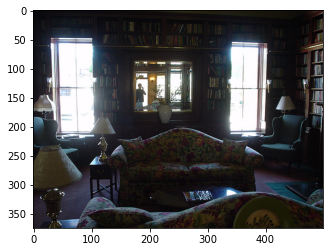

Original Support Image:


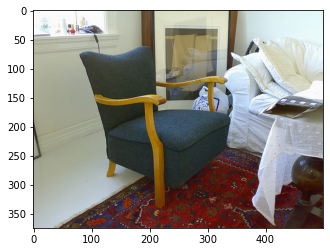

Transformed Support Image with setting 3000:


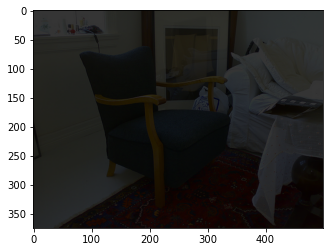

In [61]:
color_vis_3000.shownext()

Query Image:


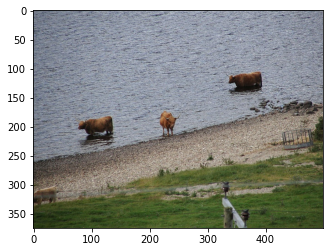

Original Support Image:


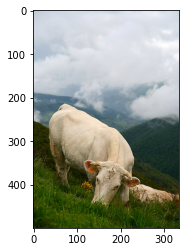

Transformed Support Image with setting 1000:


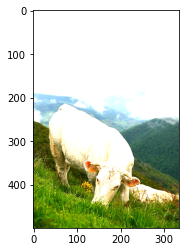

In [62]:
color_vis_1000.shownext()

Query Image:


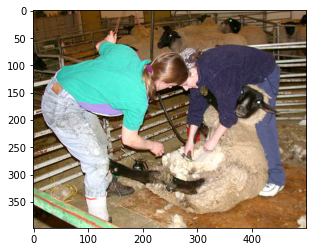

Original Support Image:


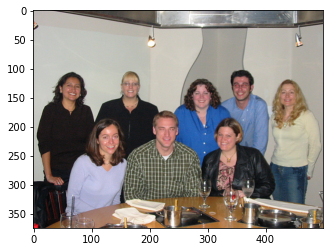

Transformed Support Image with setting 0030:


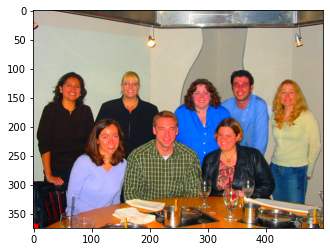

In [63]:
color_vis_0030.shownext()

In [64]:
color_vis_0000 = ColorJitterVisualizer(cfg,0,0,0,0)

Processing data for [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


100%|█████████████████████████████████████| 5953/5953 [00:03<00:00, 1528.09it/s]


Augmenting data using the following setting 0000


Query Image:


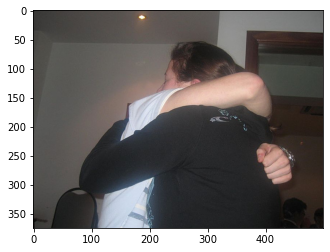

Original Support Image:


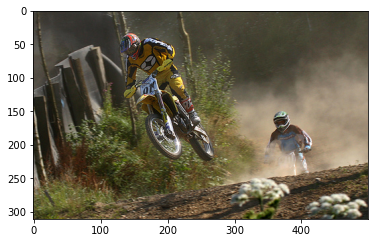

Transformed Support Image with setting 0000:


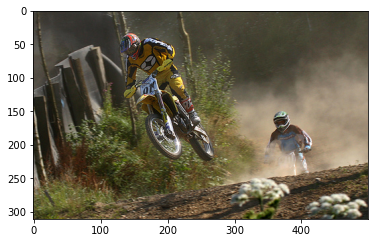

In [66]:
color_vis_0000.shownext()